In [7]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
from scrapData import GetHouseList
import re
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing,linear_model
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,RandomizedSearchCV
from sklearn.feature_selection import f_regression,SelectKBest
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import PolynomialFeatures,OneHotEncoder,LabelEncoder,MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model,ensemble
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.decomposition import PCA,TruncatedSVD
from scipy.stats import pearsonr
import pickle
np.random.seed(123)


# Loading Data

In [121]:
df=pd.read_csv('Data/olx_data_all_withGardinia.csv')
df.head()

,Amenities,Bedrooms,Bathrooms,Area (m²),Furnished,Level,Ad Type,Type,Payment Option,price,title,location,Compound
0,"Balcony,Security,Covered Parking,Electricity M...",3,2,135,No,5,For Sale,Apartment,Cash,"1,600,000 EGP",مدينتي ١٣٥م بال B1 بحري قريبه جدا من الخدم...,Madinaty,Madinaty
1,"Balcony,Pets Allowed,Private Garden,Security,E...",3,2,140,No,2,For Sale,Apartment,Cash,"355,000 EGPnegotiable",شقة بسعر التكلفة في الحي المتميز مدينة بدر...,Badr City,El Ashgar District
2,NaN,3,3,180,No,Ground,For Sale,Apartment,Cash,"3,100,000 EGP",فرررصة برحاب ٢ للبيع شقة ١٨٠م ارضي بحديقة ...,Rehab City,NaN
3,"Balcony,Pets Allowed,Security,Electricity Mete...",2,1,107,No,6,For Sale,Apartment,Cash,"1,150,000 EGP",شقة بمدينتي بال B1 نموذج 100 اقل من سعر ال...,Madinaty,Madinaty
4,"Balcony,Electricity Meter",2,1,80,No,6,For Sale,Apartment,Cash,"185,000 EGP",شقة تشطيب فاخر للبيع,Marg,NaN


# Data Cleaning

In [122]:
df.shape

(22602, 13)

In [123]:
# remove measure unit of price(EGP)
df['price']=df['price'].apply(lambda x: x.replace('EGP','').replace(',','').replace('negotiable','').strip())
df.head()

,Amenities,Bedrooms,Bathrooms,Area (m²),Furnished,Level,Ad Type,Type,Payment Option,price,title,location,Compound
0,"Balcony,Security,Covered Parking,Electricity M...",3,2,135,No,5,For Sale,Apartment,Cash,1600000,مدينتي ١٣٥م بال B1 بحري قريبه جدا من الخدم...,Madinaty,Madinaty
1,"Balcony,Pets Allowed,Private Garden,Security,E...",3,2,140,No,2,For Sale,Apartment,Cash,355000,شقة بسعر التكلفة في الحي المتميز مدينة بدر...,Badr City,El Ashgar District
2,NaN,3,3,180,No,Ground,For Sale,Apartment,Cash,3100000,فرررصة برحاب ٢ للبيع شقة ١٨٠م ارضي بحديقة ...,Rehab City,NaN
3,"Balcony,Pets Allowed,Security,Electricity Mete...",2,1,107,No,6,For Sale,Apartment,Cash,1150000,شقة بمدينتي بال B1 نموذج 100 اقل من سعر ال...,Madinaty,Madinaty
4,"Balcony,Electricity Meter",2,1,80,No,6,For Sale,Apartment,Cash,185000,شقة تشطيب فاخر للبيع,Marg,NaN


In [124]:
df['Payment Option'].unique()

array(['Cash', 'Cash or Installment', 'Installment', nan], dtype=object)

In [125]:
# remove property type where all properties are Apartments
df.drop(['Type','Ad Type','Payment Option'],axis=1,inplace=True)
df.columns

Index(['Amenities', 'Bedrooms', 'Bathrooms', 'Area (m²)', 'Furnished', 'Level',
       'price', 'title', 'location', 'Compound'],
      dtype='object')

In [126]:
#rename Area (m²) to Area 
df.rename(columns={'Area (m²)':'Area'},inplace=True)

In [127]:
#check null values
df.isna().sum()

Amenities     6936
Bedrooms         0
Bathrooms        0
Area             0
Furnished     4194
Level            5
price            0
title            0
location         0
Compound     16254
dtype: int64

In [128]:
df.Compound.value_counts()

Madinaty                2166
Rehab City               596
Abu Al-Hool              389
Not in Compound          297
Dar Misr                 231
                        ... 
Alex West                  1
Zizinia El Mostakbal       1
Gladios Garden             1
Haptown                    1
Lakefront                  1
Name: Compound, Length: 212, dtype: int64

In [129]:
# fill aminities NaN with No
df.Amenities.fillna('No',inplace=True)
df.Furnished.fillna('No',inplace=True)
df.Compound.fillna('Not in Compound',inplace=True)
df.head()

,Amenities,Bedrooms,Bathrooms,Area,Furnished,Level,price,title,location,Compound
0,"Balcony,Security,Covered Parking,Electricity M...",3,2,135,No,5,1600000,مدينتي ١٣٥م بال B1 بحري قريبه جدا من الخدم...,Madinaty,Madinaty
1,"Balcony,Pets Allowed,Private Garden,Security,E...",3,2,140,No,2,355000,شقة بسعر التكلفة في الحي المتميز مدينة بدر...,Badr City,El Ashgar District
2,No,3,3,180,No,Ground,3100000,فرررصة برحاب ٢ للبيع شقة ١٨٠م ارضي بحديقة ...,Rehab City,Not in Compound
3,"Balcony,Pets Allowed,Security,Electricity Mete...",2,1,107,No,6,1150000,شقة بمدينتي بال B1 نموذج 100 اقل من سعر ال...,Madinaty,Madinaty
4,"Balcony,Electricity Meter",2,1,80,No,6,185000,شقة تشطيب فاخر للبيع,Marg,Not in Compound


In [130]:
df.Furnished.value_counts()

No     21123
Yes     1479
Name: Furnished, dtype: int64

In [131]:
#check level values
print(df.Level.unique(),pd.isnull( df.Level).sum(),df.Level.mode()[0])

['5' '2' 'Ground' '6' '4' '3' '1' '8' '10+' '9' '7' 'Highest' '10' nan] 5 2


In [132]:
df.Level.replace('Ground','0',inplace=True)
df.Level.replace('10+','10',inplace=True)
df.Level.replace('Highest','11',inplace=True)
df.Level.fillna(str(df.Level.mode()[0]),inplace=True)
df.Level.unique()

array(['5', '2', '0', '6', '4', '3', '1', '8', '10', '9', '7', '11'],
      dtype=object)

In [133]:
df.isna().sum()

Amenities    0
Bedrooms     0
Bathrooms    0
Area         0
Furnished    0
Level        0
price        0
title        0
location     0
Compound     0
dtype: int64

In [134]:
# check all values of Bedrooms columns
df.Bedrooms.unique()

array(['3', '2', '4', '8', '1', '5', '6', '7', '9', '10', '10+'],
      dtype=object)

In [135]:
df.Bedrooms.replace('10+','10',inplace=True)
df.Bedrooms.unique()

array(['3', '2', '4', '8', '1', '5', '6', '7', '9', '10'], dtype=object)

In [136]:
# check all values of Bedrooms columns
df.Bathrooms.unique()

array(['2', '3', '1', '4', '5', '7', '8', '6', '10+', '10', '9'],
      dtype=object)

In [137]:
df.Bathrooms.replace('10+','10',inplace=True)
df.Bathrooms.unique()

array(['2', '3', '1', '4', '5', '7', '8', '6', '10', '9'], dtype=object)

In [138]:
df.Area=df.Area.apply(lambda x: x.replace(',',''))
df.Area.unique()

array(['135', '140', '180', '107', '80', '70', '85', '130', '100', '120',
       '90', '82', '177', '207', '86', '175', '211', '215', '220', '65',
       '114', '115', '204', '96', '150', '165', '103', '210', '110',
       '266', '240', '300', '200', '170', '230', '182', '146', '153',
       '125', '75', '138', '166', '225', '750', '145', '163', '122',
       '131', '155', '60', '154', '156', '223', '224', '205', '83', '185',
       '133', '250', '190', '178', '105', '108', '164', '196', '124',
       '162', '217', '160', '260', '137', '92', '209', '152', '157',
       '191', '139', '116', '62', '335', '171', '76', '202', '278', '320',
       '186', '127', '123', '350', '38', '265', '199', '117', '255', '77',
       '226', '64', '241', '73', '132', '400', '134', '113', '158', '118',
       '72', '67', '201', '136', '88', '245', '270', '10', '63', '195',
       '192', '168', '360', '161', '91', '272', '167', '126', '99', '290',
       '176', '594', '187', '148', '128', '143', '251', '20

In [139]:
df.head()

,Amenities,Bedrooms,Bathrooms,Area,Furnished,Level,price,title,location,Compound
0,"Balcony,Security,Covered Parking,Electricity M...",3,2,135,No,5,1600000,مدينتي ١٣٥م بال B1 بحري قريبه جدا من الخدم...,Madinaty,Madinaty
1,"Balcony,Pets Allowed,Private Garden,Security,E...",3,2,140,No,2,355000,شقة بسعر التكلفة في الحي المتميز مدينة بدر...,Badr City,El Ashgar District
2,No,3,3,180,No,0,3100000,فرررصة برحاب ٢ للبيع شقة ١٨٠م ارضي بحديقة ...,Rehab City,Not in Compound
3,"Balcony,Pets Allowed,Security,Electricity Mete...",2,1,107,No,6,1150000,شقة بمدينتي بال B1 نموذج 100 اقل من سعر ال...,Madinaty,Madinaty
4,"Balcony,Electricity Meter",2,1,80,No,6,185000,شقة تشطيب فاخر للبيع,Marg,Not in Compound


In [140]:
# reorder columns
df=df.loc[:,['Amenities','Bedrooms','Bathrooms','Area','Furnished','Level','location','Compound','price','title']]
df.head()

,Amenities,Bedrooms,Bathrooms,Area,Furnished,Level,location,Compound,price,title
0,"Balcony,Security,Covered Parking,Electricity M...",3,2,135,No,5,Madinaty,Madinaty,1600000,مدينتي ١٣٥م بال B1 بحري قريبه جدا من الخدم...
1,"Balcony,Pets Allowed,Private Garden,Security,E...",3,2,140,No,2,Badr City,El Ashgar District,355000,شقة بسعر التكلفة في الحي المتميز مدينة بدر...
2,No,3,3,180,No,0,Rehab City,Not in Compound,3100000,فرررصة برحاب ٢ للبيع شقة ١٨٠م ارضي بحديقة ...
3,"Balcony,Pets Allowed,Security,Electricity Mete...",2,1,107,No,6,Madinaty,Madinaty,1150000,شقة بمدينتي بال B1 نموذج 100 اقل من سعر ال...
4,"Balcony,Electricity Meter",2,1,80,No,6,Marg,Not in Compound,185000,شقة تشطيب فاخر للبيع


In [141]:
# convert funished category
df.Furnished=df.Furnished.replace({'No':0,'Yes':1})

In [142]:
# check data types
df.dtypes

Amenities    object
Bedrooms     object
Bathrooms    object
Area         object
Furnished     int64
Level        object
location     object
Compound     object
price        object
title        object
dtype: object

In [143]:
# change bedrooms, bathrooms and area into integers, and price into float
df.Bedrooms=df.Bedrooms.astype(int)
df.Bathrooms=df.Bathrooms.astype(int)
df.Area=df.Area.astype(float)
df.Level=df.Level.astype(int)
df.price=df.price.astype(float)
df.dtypes

Amenities     object
Bedrooms       int32
Bathrooms      int32
Area         float64
Furnished      int64
Level          int32
location      object
Compound      object
price        float64
title         object
dtype: object

In [144]:
df.head()

,Amenities,Bedrooms,Bathrooms,Area,Furnished,Level,location,Compound,price,title
0,"Balcony,Security,Covered Parking,Electricity M...",3,2,135.0,0,5,Madinaty,Madinaty,1600000.0,مدينتي ١٣٥م بال B1 بحري قريبه جدا من الخدم...
1,"Balcony,Pets Allowed,Private Garden,Security,E...",3,2,140.0,0,2,Badr City,El Ashgar District,355000.0,شقة بسعر التكلفة في الحي المتميز مدينة بدر...
2,No,3,3,180.0,0,0,Rehab City,Not in Compound,3100000.0,فرررصة برحاب ٢ للبيع شقة ١٨٠م ارضي بحديقة ...
3,"Balcony,Pets Allowed,Security,Electricity Mete...",2,1,107.0,0,6,Madinaty,Madinaty,1150000.0,شقة بمدينتي بال B1 نموذج 100 اقل من سعر ال...
4,"Balcony,Electricity Meter",2,1,80.0,0,6,Marg,Not in Compound,185000.0,شقة تشطيب فاخر للبيع


# Explaratory data analysis

In [145]:
#check correllation of feature with the predicted variable (price)
df[['Bedrooms','Bathrooms','Area','Level','Furnished','price']].corr()

,Bedrooms,Bathrooms,Area,Level,Furnished,price
Bedrooms,1.000000,0.501941,-0.005364,0.046264,-0.009444,0.235967
Bathrooms,0.501941,1.000000,-0.002762,-0.077131,-0.000988,0.382985
Area,-0.005364,-0.002762,1.000000,-0.001604,-0.000562,-0.004602
Level,0.046264,-0.077131,-0.001604,1.000000,0.043166,-0.051438
Furnished,-0.009444,-0.000988,-0.000562,0.043166,1.000000,0.061817
price,0.235967,0.382985,-0.004602,-0.051438,0.061817,1.000000


it seems that all correlations are weak

#### >> Price

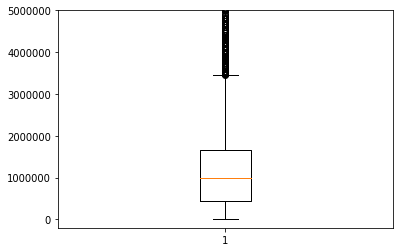

In [146]:
plt.boxplot(df.price)
plt.ylim(-200000,5000000)
plt.show()

In [147]:
#check price stats
median = np.median(df.price)
upper_quartile = np.percentile(df.price, 75)
lower_quartile = np.percentile(df.price, 25)
iqr = upper_quartile - lower_quartile
upper_whisker = df.price[df.price<=upper_quartile+1.5*iqr].max()
lower_whisker = df.price[df.price>=lower_quartile-1.5*iqr].min()
print("median: {} , Q3: {}, Q1: {},upper_whisker: {} ,lower_whisker: {}".format(median,upper_quartile,lower_quartile,upper_whisker,lower_whisker))

median: 999999.0 , Q3: 1650000.0, Q1: 450000.0,upper_whisker: 3450000.0 ,lower_whisker: 800.0


In [148]:
# check number of outliers in price
df[df.price>3750000].shape

(737, 10)

In [149]:
# remove price outliers
df=df[df.price<3750000]

In [150]:
# check number of outliers in price
df[df.price<100000].shape

(1042, 10)

In [151]:
# remove price outliers
print(df[df.price.between(100000,3750000)].shape)
df=df[df.price.between(100000,3750000)]

(20806, 10)


#### Enhancing correlation

#### >>Area

(-50, 500)

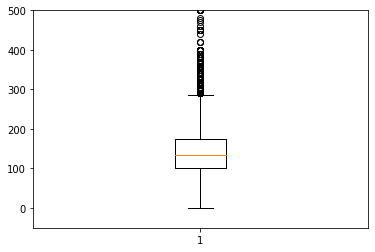

In [152]:
plt.boxplot(df.Area)
plt.ylim(-50,500)

In [153]:
median = np.median(df.Area)
upper_quartile = np.percentile(df.Area, 75)
lower_quartile = np.percentile(df.Area, 25)

iqr = upper_quartile - lower_quartile
upper_whisker = df.Area[df.Area<=upper_quartile+1.5*iqr].max()
lower_whisker = df.Area[df.Area>=lower_quartile-1.5*iqr].min()
print("median: {} , Q3: {}, Q1: {},upper_whisker: {} ,lower_whisker: {}".format(median,upper_quartile,lower_quartile,upper_whisker,lower_whisker))

median: 135.0 , Q3: 175.0, Q1: 100.0,upper_whisker: 287.0 ,lower_whisker: 0.0


In [154]:
df[df.Area>287].shape

(336, 10)

In [155]:
df[df.Area<50].shape

(32, 10)

In [156]:
# remove Area outliers
df=df[df.Area.between(50,287)]
df.shape

(20438, 10)

In [157]:
# check corr
df[['Area','price']].corr()

,Area,price
Area,1.000000,0.674181
price,0.674181,1.000000


after removing outliers from price and area we increased the area correlation from -0.003480 to 0.672541

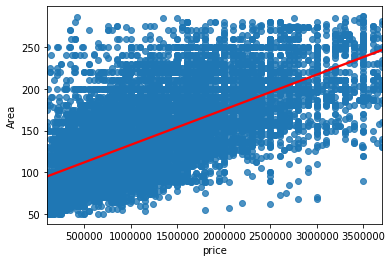

In [158]:
sns.regplot(df.price,df.Area,line_kws = {'color': 'red'})


#### >> Bathroom

{'whiskers': [<matplotlib.lines.Line2D at 0xaab22bb688>,
 'caps': [<matplotlib.lines.Line2D at 0xaab22f99c8>,
 'boxes': [<matplotlib.lines.Line2D at 0xaab22f46c8>],
 'medians': [<matplotlib.lines.Line2D at 0xaab22f9b48>],
 'fliers': [<matplotlib.lines.Line2D at 0xaab22ffa08>],
 'means': []}

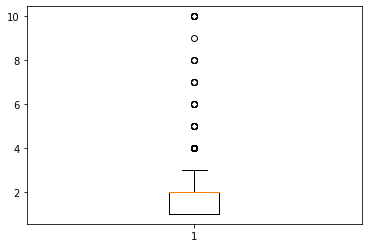

In [159]:
plt.boxplot( df.Bathrooms)

In [160]:
#chek numbers of outliers
df[df.Bathrooms>3].shape

(173, 10)

In [161]:
#chek numbers of outliers
df[df.Bathrooms==0].shape

(0, 10)

In [162]:
# remove Bathrooms outliers
df=df[df.Bathrooms<=3]

In [163]:
#check correlation
df[['Bathrooms','price']].corr()

,Bathrooms,price
Bathrooms,1.000000,0.677664
price,0.677664,1.000000


after removing outliers from bathroom we icreased the correlation from 0.365814 to 0.675171

#### >> Bedrooms

{'whiskers': [<matplotlib.lines.Line2D at 0xaab2326c88>,
 'caps': [<matplotlib.lines.Line2D at 0xaab235bfc8>,
 'boxes': [<matplotlib.lines.Line2D at 0xaab2352ec8>],
 'medians': [<matplotlib.lines.Line2D at 0xaab2360dc8>],
 'fliers': [<matplotlib.lines.Line2D at 0xaab2360ec8>],
 'means': []}

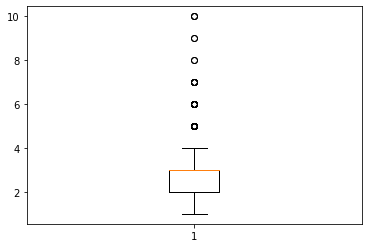

In [164]:
#check data distribution
plt.boxplot(df.Bedrooms)

In [165]:
#check price stats
median = np.median(df.Bedrooms)
upper_quartile = np.percentile(df.Bedrooms, 75)
lower_quartile = np.percentile(df.Bedrooms, 25)
iqr = upper_quartile - lower_quartile
upper_whisker = df.Bedrooms[df.Bedrooms<=upper_quartile+1.5*iqr].max()
lower_whisker = df.Bedrooms[df.Bedrooms>=lower_quartile-1.5*iqr].min()
print("median: {} , Q3: {}, Q1: {},upper_whisker: {} ,lower_whisker: {}".format(median,upper_quartile,lower_quartile,upper_whisker,lower_whisker))

median: 3.0 , Q3: 3.0, Q1: 2.0,upper_whisker: 4 ,lower_whisker: 1


In [166]:
# check shape of outliers
df[df.Bedrooms>4].shape

(90, 10)

In [167]:
# remove outliers of Bedrooms
df=df[df.Bedrooms<=4]

In [168]:
# check correlation
df[['Bedrooms','price']].corr()

,Bedrooms,price
Bedrooms,1.000000,0.363072
price,0.363072,1.000000


after removing outliers from Bedroom we icreased the correlation from 0.276485 to 0.359961

#### >> Level

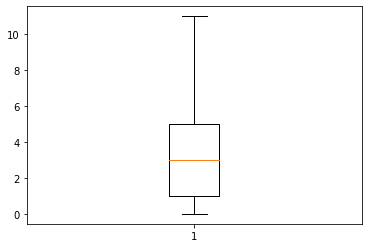

In [169]:
plt.boxplot(df.Level)
plt.show()

In [170]:
df[['Level','price']].corr()

,Level,price
Level,1.000000,-0.151718
price,-0.151718,1.000000


#### >> Furnished

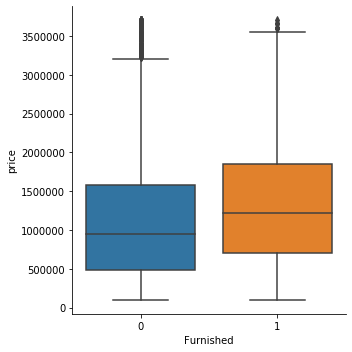

In [171]:
sns.catplot(x="Furnished", y="price", kind="box", data=df)

most of data are overlapped(small variance between data)

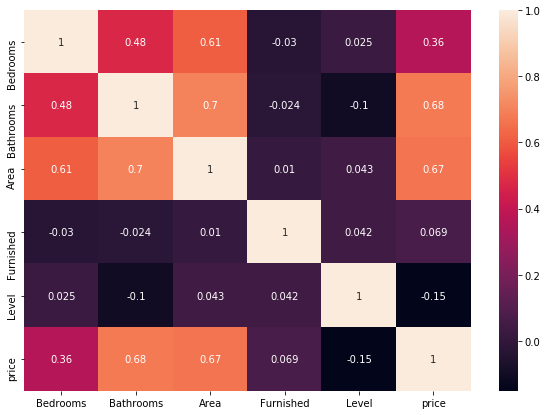

In [172]:
#### check final correlation
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(),annot = True)

### Add More Features

In [173]:
df.head()

,Amenities,Bedrooms,Bathrooms,Area,Furnished,Level,location,Compound,price,title
0,"Balcony,Security,Covered Parking,Electricity M...",3,2,135.0,0,5,Madinaty,Madinaty,1600000.0,مدينتي ١٣٥م بال B1 بحري قريبه جدا من الخدم...
1,"Balcony,Pets Allowed,Private Garden,Security,E...",3,2,140.0,0,2,Badr City,El Ashgar District,355000.0,شقة بسعر التكلفة في الحي المتميز مدينة بدر...
2,No,3,3,180.0,0,0,Rehab City,Not in Compound,3100000.0,فرررصة برحاب ٢ للبيع شقة ١٨٠م ارضي بحديقة ...
3,"Balcony,Pets Allowed,Security,Electricity Mete...",2,1,107.0,0,6,Madinaty,Madinaty,1150000.0,شقة بمدينتي بال B1 نموذج 100 اقل من سعر ال...
4,"Balcony,Electricity Meter",2,1,80.0,0,6,Marg,Not in Compound,185000.0,شقة تشطيب فاخر للبيع


In [174]:
df.shape

(20175, 10)

#### >> Compound

In [175]:

df_comp=df[df.Compound.isin(df.Compound.value_counts().reset_index(name='count').query('count>50')['index'])]
df_comp.Compound.value_counts()

Not in Compound            14808
Madinaty                    2033
Rehab City                   556
Abu Al-Hool                  329
The Square                   211
Dar Misr                     208
Mountain View Hyde Park      182
VGK                          167
Eastown                      135
Galleria Moon Valley          81
2020 Compound                 79
Stone Residence               77
Baron City                    77
Tag Sultan                    52
Name: Compound, dtype: int64

<Figure size 1440x720 with 0 Axes>

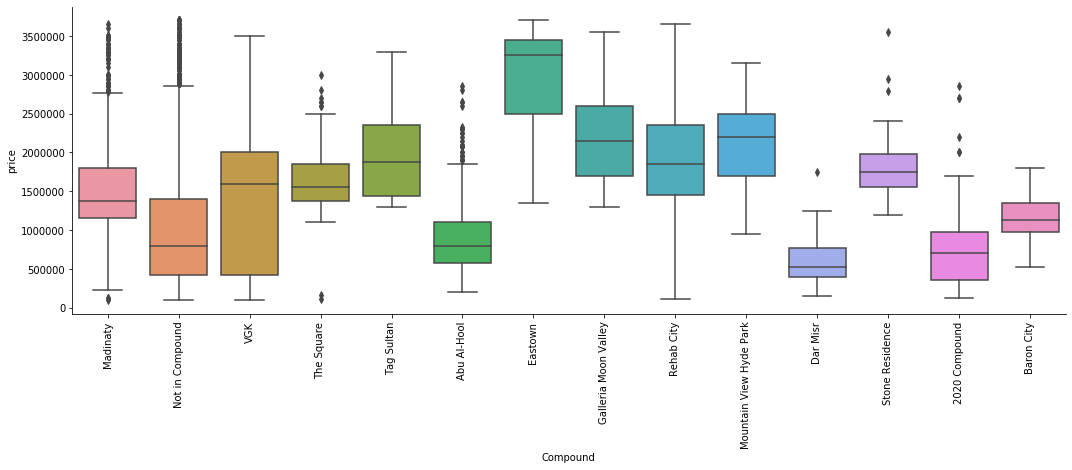

In [176]:
plt.figure(figsize=(20,10))
sns.catplot(x='Compound',y='price',kind="box", data=df_comp,height=5, # make the plot 5 units high
    aspect=3)
plt.xticks(rotation=90)
plt.show()

#### >> City

In [177]:
df_comp.location.value_counts().sort_values()[:20]

Garden City           5
Darrasa               6
Ataba                 7
Tebeen                7
Moski                 8
Ma'sara               8
Gamaleya             10
Darb al-Ahmar        11
Boulaq               13
Tura                 16
Bab al-Shereia       16
El Fostat            26
Rod al-Farag         28
New Heliopolis       28
Helmeya al-Gadeda    29
New Capital City     31
Qasr al-Nil          33
Mostakbal City       36
Basateen             36
Al Amiriyyah         39
Name: location, dtype: int64

In [178]:
df_comp_loc=df_comp[df_comp.location.isin(df_comp.location.value_counts().reset_index(name='count').query('count>50')['index'])]
df_comp_loc.location.value_counts().sort_values()[:7]

Waili              56
Katameya           59
Abasiya            61
Al Manial          70
Zawya al-Hamra     97
Dar al-Salaam     104
Ezbet El Nakhl    126
Name: location, dtype: int64

<Figure size 1440x360 with 0 Axes>

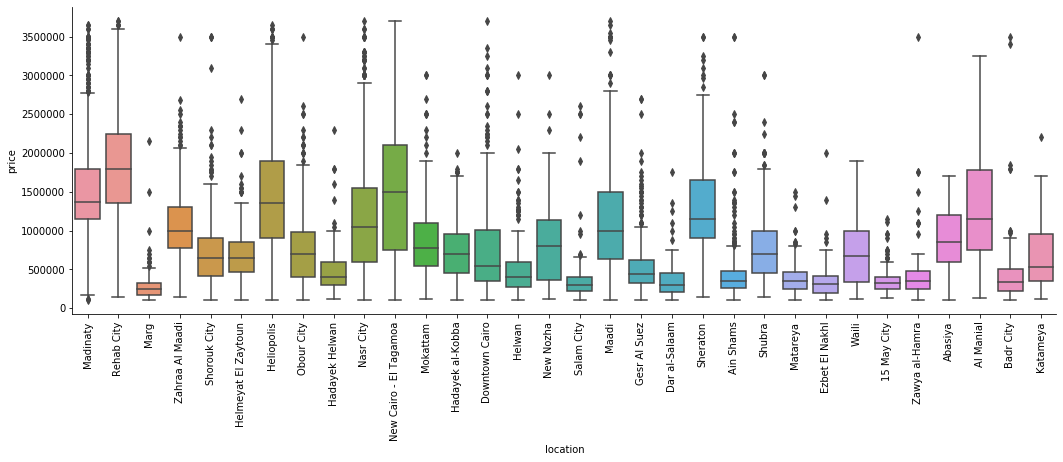

In [179]:
plt.figure(figsize=(20,5))
sns.catplot(x='location',y='price',kind="box", data=df_comp_loc,height=5, # make the plot 5 units high
    aspect=3)
plt.xticks(rotation=90)
plt.show()

In [180]:
print(df_comp_loc.shape)

(18338, 10)


In [181]:
# check significancy of Compound
enc = LabelEncoder()
df_comp['LabeledCompound']=enc.fit_transform(df_comp['Compound'])
df_comp['Labeledlocation']=enc.fit_transform(df_comp['location'])

G:\Users\SAAD\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
G:\Users\SAAD\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [182]:
cols=df_comp.loc[:, df_comp.columns[1:6].append(df_comp.columns[10:12])].columns
cols

Index(['Bedrooms', 'Bathrooms', 'Area', 'Furnished', 'Level',
       'LabeledCompound', 'Labeledlocation'],
      dtype='object')

In [183]:
from sklearn.feature_selection import chi2
res = chi2(df_comp.loc[:, df_comp.columns[1:6].append(df_comp.columns[10:12])], df_comp['price'])
features = pd.DataFrame({
    'features': cols,
    'chi2': res[0],
    'p-value': res[1]
})
features

,features,chi2,p-value
0,Bedrooms,455.173106,9.999997e-01
1,Bathrooms,3070.700164,0.000000e+00
2,Area,156255.548115,0.000000e+00
3,Furnished,823.329655,2.934442e-08
4,Level,2508.675826,1.274700e-226
5,LabeledCompound,543.585624,9.808937e-01
6,Labeledlocation,8587.213357,0.000000e+00


#### >> Aminities

In [184]:
# convert comma separated aminities into lists
df_comp_loc['Amenities']=df_comp_loc.Amenities.apply(lambda x: x.split(','))
df_comp_loc.head()

G:\Users\SAAD\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Amenities,Bedrooms,Bathrooms,Area,Furnished,Level,location,Compound,price,title
0,"[Balcony, Security, Covered Parking, Electrici...",3,2,135.0,0,5,Madinaty,Madinaty,1600000.0,مدينتي ١٣٥م بال B1 بحري قريبه جدا من الخدم...
2,[No],3,3,180.0,0,0,Rehab City,Not in Compound,3100000.0,فرررصة برحاب ٢ للبيع شقة ١٨٠م ارضي بحديقة ...
3,"[Balcony, Pets Allowed, Security, Electricity ...",2,1,107.0,0,6,Madinaty,Madinaty,1150000.0,شقة بمدينتي بال B1 نموذج 100 اقل من سعر ال...
4,"[Balcony, Electricity Meter]",2,1,80.0,0,6,Marg,Not in Compound,185000.0,شقة تشطيب فاخر للبيع
6,"[Electricity Meter, Water Meter, Natural Gas]",3,1,85.0,0,6,Zahraa Al Maadi,Not in Compound,290000.0,شقة للبيع العمارات مصر العليا واجهة بحرية ...


In [185]:
df_comp_loc.shape

(18338, 10)

In [186]:
mlb = MultiLabelBinarizer()
multiLabelBinarizer_df = df_comp_loc.join(pd.DataFrame(mlb.fit_transform(df_comp_loc['Amenities']),
                          columns=mlb.classes_,
                          index=df_comp_loc.index))
print(multiLabelBinarizer_df.columns)
multiLabelBinarizer_df.iloc[:,8:].head()

Index(['Amenities', 'Bedrooms', 'Bathrooms', 'Area', 'Furnished', 'Level',
       'location', 'Compound', 'price', 'title', 'Balcony',
       'Built in Kitchen Appliances', 'Central A/C & heating',
       'Covered Parking', 'Electricity Meter', 'Elevator', 'Landline',
       'Maids Room', 'Natural Gas', 'No', 'Pets Allowed', 'Pool',
       'Private Garden', 'Security', 'Water Meter'],
      dtype='object')


,price,title,Balcony,Built in Kitchen Appliances,Central A/C & heating,Covered Parking,Electricity Meter,Elevator,Landline,Maids Room,Natural Gas,No,Pets Allowed,Pool,Private Garden,Security,Water Meter
0,1600000.0,مدينتي ١٣٥م بال B1 بحري قريبه جدا من الخدم...,1,0,0,1,1,1,1,0,0,0,0,0,0,1,1
2,3100000.0,فرررصة برحاب ٢ للبيع شقة ١٨٠م ارضي بحديقة ...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,1150000.0,شقة بمدينتي بال B1 نموذج 100 اقل من سعر ال...,1,0,0,0,1,1,0,0,0,0,1,0,0,1,1
4,185000.0,شقة تشطيب فاخر للبيع,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
6,290000.0,شقة للبيع العمارات مصر العليا واجهة بحرية ...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1


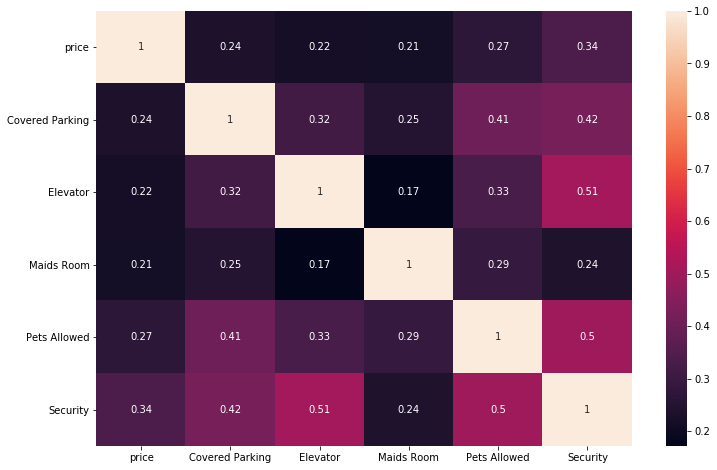

In [187]:
# check top features
corr=multiLabelBinarizer_df.iloc[:,8:].corr()
top_feature = corr.index[abs(corr['price']>=0.2)]
plt.subplots(figsize=(12, 8))
top_corr = multiLabelBinarizer_df[top_feature].corr()
sns.heatmap(top_corr, annot=True)
plt.show()

In [188]:
multiLabelBinarizer_df[multiLabelBinarizer_df.columns.difference(list(top_feature))].columns

Index(['Amenities', 'Area', 'Balcony', 'Bathrooms', 'Bedrooms',
       'Built in Kitchen Appliances', 'Central A/C & heating', 'Compound',
       'Electricity Meter', 'Furnished', 'Landline', 'Level', 'Natural Gas',
       'No', 'Pool', 'Private Garden', 'Water Meter', 'location', 'title'],
      dtype='object')

In [189]:
df_comp_loc_amnt=df_comp_loc.copy().reset_index(drop=True)
df_comp_loc_amnt.head(1)

,Amenities,Bedrooms,Bathrooms,Area,Furnished,Level,location,Compound,price,title
0,"[Balcony, Security, Covered Parking, Electrici...",3,2,135.0,0,5,Madinaty,Madinaty,1600000.0,مدينتي ١٣٥م بال B1 بحري قريبه جدا من الخدم...


In [190]:
# test the not correlated aminities functionality
not_correlated_features=list(multiLabelBinarizer_df[multiLabelBinarizer_df.columns.difference(list(top_feature))].columns)
for index,aminities in enumerate(df_comp_loc_amnt.Amenities[:4]):
    print(index,aminities)
    print(list(set(aminities) - set(not_correlated_features)))
    print("--------------------------------------")
    

0 ['Balcony', 'Security', 'Covered Parking', 'Electricity Meter', 'Water Meter', 'Landline', 'Elevator']
['Security', 'Covered Parking', 'Elevator']
--------------------------------------
1 ['No']
[]
--------------------------------------
2 ['Balcony', 'Pets Allowed', 'Security', 'Electricity Meter', 'Water Meter', 'Elevator']
['Security', 'Pets Allowed', 'Elevator']
--------------------------------------
3 ['Balcony', 'Electricity Meter']
[]
--------------------------------------


In [191]:
def RemoveNotCorrelated(aminities):
    correlated_list=list(set(aminities) - set(not_correlated_features))
    return correlated_list

In [192]:
# remove the not correlated aminities
not_correlated_features=list(multiLabelBinarizer_df[multiLabelBinarizer_df.columns.difference(list(top_feature))].columns)
df_comp_loc_amnt.Amenities=df_comp_loc_amnt.Amenities.apply(lambda x: RemoveNotCorrelated(x))
df_comp_loc_amnt.head()

,Amenities,Bedrooms,Bathrooms,Area,Furnished,Level,location,Compound,price,title
0,"[Security, Covered Parking, Elevator]",3,2,135.0,0,5,Madinaty,Madinaty,1600000.0,مدينتي ١٣٥م بال B1 بحري قريبه جدا من الخدم...
1,[],3,3,180.0,0,0,Rehab City,Not in Compound,3100000.0,فرررصة برحاب ٢ للبيع شقة ١٨٠م ارضي بحديقة ...
2,"[Security, Pets Allowed, Elevator]",2,1,107.0,0,6,Madinaty,Madinaty,1150000.0,شقة بمدينتي بال B1 نموذج 100 اقل من سعر ال...
3,[],2,1,80.0,0,6,Marg,Not in Compound,185000.0,شقة تشطيب فاخر للبيع
4,[],3,1,85.0,0,6,Zahraa Al Maadi,Not in Compound,290000.0,شقة للبيع العمارات مصر العليا واجهة بحرية ...


In [193]:
#test on CountVectorizer to be used in pipeline
vectorizer=CountVectorizer(analyzer=set)
X2=vectorizer.fit_transform(df_comp_loc_amnt['Amenities'])
print(list(df_comp_loc_amnt.iloc[0:4,0].values))

[['Security', 'Covered Parking', 'Elevator'], [], ['Security', 'Pets Allowed', 'Elevator'], []]


In [194]:
vectorized_df=pd.DataFrame(X2.toarray(),columns=vectorizer.get_feature_names())
print(vectorized_df.shape,df_comp_loc_amnt.shape)
vectorized_df.head(4)

(18338, 5) (18338, 10)


,Covered Parking,Elevator,Maids Room,Pets Allowed,Security
0,1,1,0,0,1
1,0,0,0,0,0
2,0,1,0,1,1
3,0,0,0,0,0


In [195]:
df_comp_loc_amnt.to_csv('olx_data_cleaned_for_model.csv')

# Prediction

In [196]:
df_numerical=df_comp_loc_amnt.loc[:,df_comp_loc_amnt.columns.difference(['Amenities', 'Compound','location','title','price'])]
df_features=df_comp_loc_amnt.loc[:,df_comp_loc_amnt.columns.difference(['price','title'])]
df_target=df_comp_loc_amnt.loc[:,'price']
df_numerical.columns,df_features.columns

(Index(['Area', 'Bathrooms', 'Bedrooms', 'Furnished', 'Level'], dtype='object'),
 Index(['Amenities', 'Area', 'Bathrooms', 'Bedrooms', 'Compound', 'Furnished',
        'Level', 'location'],
       dtype='object'))

In [197]:
numeric_features = list(df_numerical.columns)
categorical_features = ['location', 'Compound']
amanities_feature='Amenities'
numeric_transformer = Pipeline(steps=[
    ('scaler', preprocessing.MinMaxScaler())])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])
countVectorizer_transformer = Pipeline(steps=[
    ('countVectorizer',CountVectorizer(analyzer=set))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('multi_label', countVectorizer_transformer, amanities_feature),
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
        ])

In [198]:
#split data to train/test
X=df_features
Y=df_target
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.1,random_state=40)
print('training set: ',X_train.shape,y_train.shape)
print('test set: ',X_test.shape,y_test.shape)
X_train.head(2)

training set:  (16504, 8) (16504,)
test set:  (1834, 8) (1834,)


,Amenities,Area,Bathrooms,Bedrooms,Compound,Furnished,Level,location
9895,[Elevator],155.0,2,3,Not in Compound,0,8,Nasr City
3855,"[Security, Covered Parking, Pets Allowed, Elev...",96.0,2,2,Madinaty,0,4,Madinaty


In [200]:
def train_model(model):
    global y_hat
    pipeline = Pipeline(steps=[('preprocessor',preprocessor),('model', model)])
    pipeline.fit(X_train,y_train)
    y_hat=pipeline.predict(X_test)
    y_hat_train=pipeline.predict(X_train)
    print('R square:{:0.2f} '.format(r2_score(y_test,y_hat))) 
    print('Train R square:{:0.2f} '.format(r2_score(y_train,y_hat_train))) 
    return pipeline

### 1. Linear Regression

In [201]:
# train the linear regression model
reg = linear_model.LinearRegression()
reg=train_model(reg)
pickle.dump(reg, open('Reg_model.pkl','wb'))

R square:0.77 
Train R square:0.76 


In [82]:
# cross validation
scores = cross_val_score(reg, X, Y, cv=50)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.76 (+/- 0.05)


In [83]:
scores

array([0.78302134, 0.80208215, 0.72400069, 0.78392963, 0.70653132,
       0.76118425, 0.74851754, 0.7735098 , 0.76592166, 0.74597688,
       0.73854941, 0.70278839, 0.7580151 , 0.76557307, 0.77143127,
       0.74016423, 0.73254353, 0.72596468, 0.78465726, 0.7726919 ,
       0.79424147, 0.76309225, 0.75057759, 0.75981987, 0.79043032,
       0.76948662, 0.76637412, 0.77856916, 0.7835588 , 0.73723627,
       0.72235228, 0.77405513, 0.77189991, 0.721679  , 0.76181616,
       0.76003177, 0.72527867, 0.77690859, 0.71693801, 0.78369264,
       0.80080601, 0.77112919, 0.77319504, 0.79375228, 0.71298526,
       0.72687507, 0.71276379, 0.75322201, 0.77368824, 0.74957306])

##### Linear Model regularization (Lasso and Ridge Regression) to prevent overfitting

In [202]:
clf_ridge = linear_model.Ridge(alpha=.09)
clf_Lasso = linear_model.Ridge(alpha=1)
train_model(clf_ridge)
train_model(clf_Lasso);

R square:0.77 
Train R square:0.76 
R square:0.77 
Train R square:0.76 


### 2. KNN

In [203]:
neigh = KNeighborsRegressor(n_neighbors=14)
neigh=train_model(neigh);
# serialize the model 
pickle.dump(neigh, open('KNN_model.pkl','wb'))

R square:0.72 
Train R square:0.76 


In [ ]:
# cross validation
scores = cross_val_score(neigh, X, Y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [87]:
scores

array([0.76639545, 0.78312428, 0.77148067, 0.74562181, 0.77254287,
       0.76573818, 0.75555871, 0.74955437, 0.75920266, 0.73994762])

### 3. GBoost

In [88]:
# check best parameter tuning
"""
p_test3 = {'model__learning_rate':[0.1,0.01,0.005],
           'model__n_estimators':[100,200,300],
           'model__min_samples_split':[2,6,10],
           'model__max_depth':[5,7,9] ,
           'model__random_state':[10]
          }

pipeline = Pipeline(steps=[('preprocessor',preprocessor),('model', ensemble.GradientBoostingRegressor())])
tuned=GridSearchCV(pipeline, 
            param_grid = p_test3,n_jobs=-1,cv=3)#cv determines number of folds,n_jobs=-1 use all CPU cores
tuned.fit(X_train, y_train)
#results = tuned.cv_results_
tuned.best_params_, tuned.best_score_
"""

"\np_test3 = {'model__learning_rate':[0.1,0.01,0.005],\n           'model__n_estimators':[100,200,300],\n           'model__min_samples_split':[2,6,10],\n           'model__max_depth':[5,7,9] ,\n           'model__random_state':[10]\n          }\n\npipeline = Pipeline(steps=[('preprocessor',preprocessor),('model', ensemble.GradientBoostingRegressor())])\ntuned=GridSearchCV(pipeline, \n            param_grid = p_test3,n_jobs=-1,cv=3)#cv determines number of folds,n_jobs=-1 use all CPU cores\ntuned.fit(X_train, y_train)\n#results = tuned.cv_results_\ntuned.best_params_, tuned.best_score_\n"

In [205]:
# check best parameter tuning
p_test3 = {'model__learning_rate':[0.001,0.005,0.01],
           'model__n_estimators':[100,500,700],
           'model__min_samples_split':[2,6,10],
           'model__max_depth':[5,7,9] 
          }

pipeline = Pipeline(steps=[('preprocessor',preprocessor),('model', ensemble.GradientBoostingRegressor())])
tuned=RandomizedSearchCV(pipeline, 
            p_test3,n_iter=10,random_state=10,cv=3)#cv determines number of folds,n_jobs=-1 use all CPU cores
tuned.fit(X_train, y_train)
results = tuned.cv_results_
tuned.best_params_, tuned.best_score_

({'model__n_estimators': 700,
  'model__min_samples_split': 2,
  'model__max_depth': 7,
  'model__learning_rate': 0.01},
 0.7925435009929673)

In [209]:
# apply best parameters
params = {'learning_rate': 0.01,#how much the contribution of each tree will shrink.
          'n_estimators': 700,#the number of boosting stages
          'max_depth': 7,#limits the number of nodes in the tree
          'min_samples_split': 5,# the minimum number of samples required to split an internal node.
          #'min_samples_leaf': 2,# the minimum number of samples required to split an internal node.
          'random_state':10,
         # 'loss': 'ls'
         }#loss function to optimize. The least squares function is used in this case

gBoost_model=ensemble.GradientBoostingRegressor(**params)
trained_gBoost_model=train_model(gBoost_model)

R square:0.81 
Train R square:0.84 


#### train the model on all data

In [211]:
acc={}
params = {'n_estimators': 700,#the number of boosting stages
          'max_depth': 7,#limits the number of nodes in the tree
          'min_samples_split': 5,# the minimum number of samples required to split an internal node.
          'learning_rate': 0.01,#how much the contribution of each tree will shrink.
           'random_state':10,
          #'loss': 'ls'
         }#loss function to optimize. The least squares function is used in this case

gBoost_model=ensemble.GradientBoostingRegressor(**params)
trained_gBoost_model = Pipeline(steps=[('preprocessor',preprocessor),('model', gBoost_model)])
trained_gBoost_model.fit(X,Y)
y_hat=trained_gBoost_model.predict(X_test)
print('R square:{:0.2f} '.format(r2_score(y_test,y_hat))) 

R square:0.85 


## Test The Model Prediction

In [212]:
# serialize the model 
pickle.dump(trained_gBoost_model, open('GBoost_model.pkl','wb'))

In [213]:
#Test Data
dict_test={'Amenities':['Central A/C & heating','Electricity Meter','Water Meter','Elevator'],'Area':211,'Bathrooms':3,'Bedrooms':3,"Compound":"Rehab City",'Furnished':0,'Level':4,'location':"Rehab City"}
columns = list(dict_test.keys())
values = list(dict_test.values())
arr_len = len(values)
test_row=pd.DataFrame(np.array(values, dtype=object).reshape(1, arr_len), columns=columns)
test_row

,Amenities,Area,Bathrooms,Bedrooms,Compound,Furnished,Level,location
0,"[Central A/C & heating, Electricity Meter, Wat...",211,3,3,Rehab City,0,4,Rehab City


In [214]:
model = pickle.load(open('GBoost_model.pkl','rb'))
print('GBoost : {:,.2f}'.format(model.predict(test_row)[0]))

GBoost : 3,072,148.99


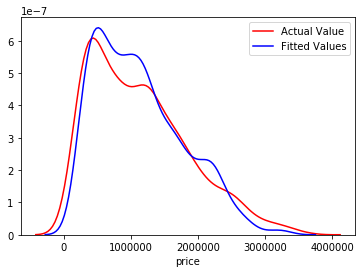

In [215]:
# check the accuracy visually
ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_hat, hist=False, color="b", label="Fitted Values" , ax=ax1)